In [1]:
# let's see what is in labels file

import pandas as pd
from cv2 import cv2
import matplotlib.pyplot as plt  # plot
import os
from os.path import join

path = ('/kaggle/input/affectnet-training-data/')
file = (path + 'labels.csv')
df = pd.read_csv(file)
df.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


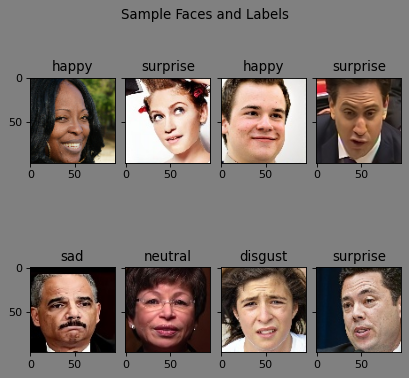

In [2]:
# display random images

import random

fig, axs = plt.subplots(2, 4, sharey=True, constrained_layout=True, num=None, 
                        figsize=(5, 5), dpi=80, facecolor='gray', edgecolor='k')
fig.suptitle("Sample Faces and Labels")
axs = axs.flatten()

for i in range(8):
    idx = random.randint(0, len(df)-1)  # randomly select an index
    img_path = path + df['pth'][idx]
    img = cv2.imread(img_path)  # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to BGR to RGB
    axs[i].imshow(img)
    axs[i].set_title(df['label'][idx])

AffectNet is a large database of faces labeled by "affects" (psychological term for facial expressions). In order to accommodate common memory constraints, the resolution was reduced down to 96x96. Meaning that all images are exactly 96x96 pixels.

# 2 ways to load and label categories

In [3]:
# # 1. define functions to pre-process and load images into arrays / label from folders


# import cv2
# import numpy as np
# from keras.utils import to_categorical
# import os

# INPUT_PATH = "/kaggle/input/affectnet-training-data/"
# EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]
# IMAGE_SIZE = (96, 96)

# print(EMOTIONS)

# def image_generator(input_path, emotions, image_size):
#     for index, emotion in enumerate(emotions):
#         for filename in os.listdir(os.path.join(input_path, emotion)):
#             img = cv2.imread(os.path.join(input_path, emotion, filename))
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
#             #img = cv2.resize(img, image_size)
#             #img = img.astype('float32') / 255.0  # Normilize
#             yield img, index

# def load_images(input_path, emotions, image_size):
#     X, y = [], []
#     for img, label in image_generator(input_path, emotions, image_size):
#         X.append(img)
#         y.append(label)
#     X = np.array(X)
#     y = to_categorical(np.array(y))
#     return X, y

In [4]:
# # Load the images 1
# X, y = load_images(INPUT_PATH, EMOTIONS, IMAGE_SIZE)
# input_shape = X[0].shape
# #input_shape = (96,96,1) 

In [5]:
# # choose a random image index
# idx = np.random.randint(len(X))

# # display the image and its corresponding label from arrays
# plt.imshow(X[idx])
# plt.title(EMOTIONS[np.argmax(y[idx])])
# plt.show()

In [6]:
# # 2. define functions to pre-process and load images into arrays / label from labels.csv file

import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from cv2 import cv2
import os
from os.path import join

path = '/kaggle/input/affectnet-training-data/'
file = join(path, 'labels.csv')
df = pd.read_csv(file)

# Define a dictionary to map emotion labels to integer labels
EMOTION_MAP = {'neutral': 0, 'happy': 1, 'sad': 2, 'surprise': 3, 'fear': 4, 'disgust': 5, 'anger': 6, 'contempt': 7}

# Map the string labels to integer labels using the dictionary
df['label'] = df['label'].apply(lambda x: EMOTION_MAP[x])

# Convert the integer labels to one-hot encoded labels
y = to_categorical(df['label'])

# Switch keys and values of the EMOTION_MAP dictionary
EMOTION_MAP = {v: k for k, v in EMOTION_MAP.items()}

IMAGE_SIZE = (96, 96)

# Define a function to pre-process and load images into arrays
def load_images_2(input_path, df, image_size):
    X = []
    for _, row in df.iterrows():
        img = cv2.imread(join(input_path, row['pth']))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        X.append(img)
    return np.array(X), y





In [7]:
# Load the images 2
X, y = load_images_2(path, df, IMAGE_SIZE)
input_shape = X[0].shape

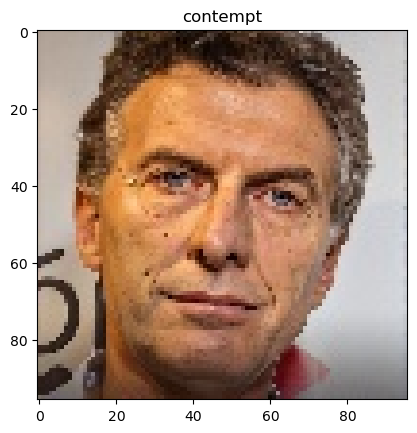

In [8]:
import matplotlib.pyplot as plt

# choose a random image index
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])

label_index = np.argmax(y[idx])
label_str = EMOTION_MAP[label_index]

plt.title(label_str)
plt.show()



In [9]:
# Train test split pre-processed data

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # create a stratified train-test split
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
# for train_index, test_index in split.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

# Model_2 from Tuning template

In [10]:
# our updated model

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_2 = Sequential()

model_2.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(128, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(256, activation='selu', kernel_regularizer=l2(0.01)))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(8, activation='softmax'))

model_2.compile(optimizer = Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45, 64)       2

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_2.fit(X_train, y_train, batch_size=64,
                    epochs=25,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/25
353/353 [==============================] - 13s 20ms/step - loss: 4.4881 - accuracy: 0.3461 - val_loss: 2.8964 - val_accuracy: 0.4092 - lr: 0.0010
Epoch 2/25
353/353 [==============================] - 7s 19ms/step - loss: 2.6513 - accuracy: 0.4593 - val_loss: 2.4363 - val_accuracy: 0.4689 - lr: 0.0010
Epoch 3/25
353/353 [==============================] - 6s 18ms/step - loss: 2.3716 - accuracy: 0.4945 - val_loss: 6.8591 - val_accuracy: 0.2958 - lr: 0.0010
Epoch 4/25
353/353 [==============================] - 7s 19ms/step - loss: 2.2926 - accuracy: 0.5178 - val_loss: 2.3063 - val_accuracy: 0.5136 - lr: 0.0010
Epoch 5/25
353/353 [==============================] - 7s 19ms/step - loss: 2.2887 - accuracy: 0.5310 - val_loss: 2.4263 - val_accuracy: 0.4978 - lr: 0.0010
Epoch 6/25
353/353 [==============================] - 7s 19ms/step - loss: 2.2703 - accuracy: 0.5458 - val_loss: 2.1624 - val_accuracy: 0.5501 - lr: 0.0010
Epoch 7/25
353/353 [==============================] - 7s 19ms/s

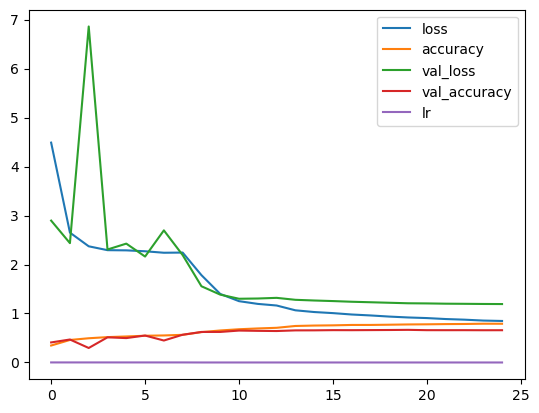

In [12]:
pd.DataFrame(history.history).plot();

In [13]:
from sklearn.metrics import r2_score

# Make predictions
y_pred = model_2.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score:", r2)

177/177 [==============================] - 1s 3ms/step
R2 score: 0.4596905936301191


In [14]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model_2.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

177/177 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.60      0.50      0.55       596
           1       0.83      0.89      0.86       838
           2       0.61      0.50      0.55       607
           3       0.64      0.72      0.68       889
           4       0.77      0.50      0.60       608
           5       0.59      0.64      0.61       711
           6       0.62      0.65      0.63       736
           7       0.61      0.76      0.67       650

    accuracy                           0.66      5635
   macro avg       0.66      0.64      0.64      5635
weighted avg       0.66      0.66      0.65      5635



# More complex model

In [15]:
# our new model_3

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_3 = Sequential()

model_3.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(64, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(128, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(256, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(256, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(8, activation='softmax'))

model_3.compile(optimizer = Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_3.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 94, 94, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 45, 45, 64)      

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_3.fit(X_train, y_train, batch_size=64,
                    epochs=25,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/25
353/353 [==============================] - 11s 28ms/step - loss: 3.3952 - accuracy: 0.3196 - val_loss: 2.1031 - val_accuracy: 0.4545 - lr: 0.0010
Epoch 2/25
353/353 [==============================] - 9s 27ms/step - loss: 1.7629 - accuracy: 0.4790 - val_loss: 1.5482 - val_accuracy: 0.4958 - lr: 0.0010
Epoch 3/25
353/353 [==============================] - 10s 29ms/step - loss: 1.4061 - accuracy: 0.5362 - val_loss: 1.2879 - val_accuracy: 0.5693 - lr: 0.0010
Epoch 4/25
353/353 [==============================] - 9s 27ms/step - loss: 1.2722 - accuracy: 0.5801 - val_loss: 1.3367 - val_accuracy: 0.5507 - lr: 0.0010
Epoch 5/25
353/353 [==============================] - 10s 27ms/step - loss: 1.1978 - accuracy: 0.6091 - val_loss: 1.2206 - val_accuracy: 0.5954 - lr: 0.0010
Epoch 6/25
353/353 [==============================] - 10s 27ms/step - loss: 1.1395 - accuracy: 0.6274 - val_loss: 1.1146 - val_accuracy: 0.6339 - lr: 0.0010
Epoch 7/25
353/353 [==============================] - 10s 28

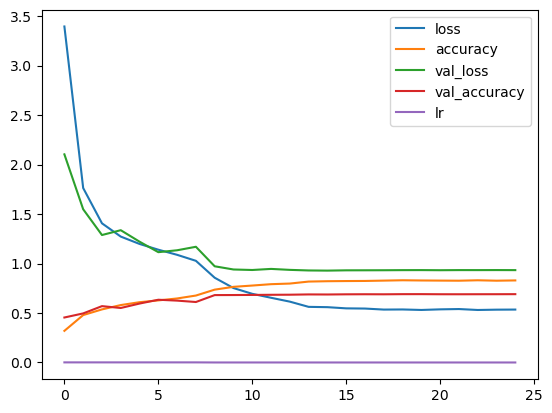

In [17]:
pd.DataFrame(history.history).plot();

In [18]:
from sklearn.metrics import r2_score

# Make predictions
y_pred = model_3.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score:", r2)

177/177 [==============================] - 1s 4ms/step
R2 score: 0.49681899498008036


In [19]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model_3.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

177/177 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.62      0.61      0.62       596
           1       0.84      0.87      0.86       838
           2       0.62      0.62      0.62       607
           3       0.69      0.72      0.70       889
           4       0.73      0.61      0.66       608
           5       0.63      0.63      0.63       711
           6       0.68      0.65      0.66       736
           7       0.67      0.75      0.70       650

    accuracy                           0.69      5635
   macro avg       0.68      0.68      0.68      5635
weighted avg       0.69      0.69      0.69      5635



# Complex model with agressive dropouts 

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_4 = Sequential()

model_4.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.3))

model_4.add(Conv2D(64, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(Conv2D(64, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.4))

model_4.add(Conv2D(128, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(Conv2D(128, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.5))

model_4.add(Conv2D(256, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(Conv2D(256, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.6))

model_4.add(Flatten())
model_4.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.5))
model_4.add(Dense(8, activation='softmax'))

model_4.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_4.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 45, 45, 64)      

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_4.fit(X_train, y_train, batch_size=128,
                    epochs=25,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(monitor='val_loss', 
                                                   factor=0.5, 
                                                   patience=2, 
                                                   verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/25
177/177 [==============================] - 12s 55ms/step - loss: 4.1887 - accuracy: 0.2324 - val_loss: 3.0377 - val_accuracy: 0.3496 - lr: 0.0010
Epoch 2/25
177/177 [==============================] - 9s 49ms/step - loss: 2.6471 - accuracy: 0.3512 - val_loss: 2.0749 - val_accuracy: 0.4311 - lr: 0.0010
Epoch 3/25
177/177 [==============================] - 9s 49ms/step - loss: 1.9240 - accuracy: 0.4296 - val_loss: 1.6660 - val_accuracy: 0.4763 - lr: 0.0010
Epoch 4/25
177/177 [==============================] - 9s 50ms/step - loss: 1.5930 - accuracy: 0.4754 - val_loss: 1.4256 - val_accuracy: 0.5271 - lr: 0.0010
Epoch 5/25
177/177 [==============================] - 9s 49ms/step - loss: 1.4440 - accuracy: 0.5119 - val_loss: 1.4174 - val_accuracy: 0.5114 - lr: 0.0010
Epoch 6/25
177/177 [==============================] - 9s 49ms/step - loss: 1.3701 - accuracy: 0.5336 - val_loss: 1.3551 - val_accuracy: 0.5375 - lr: 0.0010
Epoch 7/25
177/177 [==============================] - 9s 49ms/s

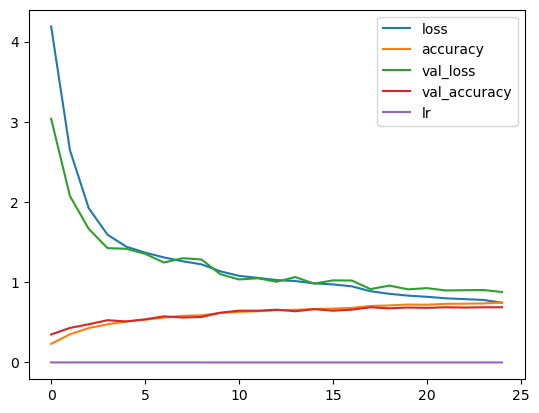

In [22]:
pd.DataFrame(history.history).plot();

In [23]:
from sklearn.metrics import r2_score

# Make predictions
y_pred = model_4.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score:", r2)

177/177 [==============================] - 1s 5ms/step
R2 score: 0.5108167204186586


In [24]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model_4.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

177/177 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.58      0.66      0.62       596
           1       0.88      0.86      0.87       838
           2       0.68      0.58      0.63       607
           3       0.62      0.76      0.68       889
           4       0.77      0.54      0.63       608
           5       0.65      0.67      0.66       711
           6       0.72      0.60      0.66       736
           7       0.66      0.75      0.70       650

    accuracy                           0.69      5635
   macro avg       0.69      0.68      0.68      5635
weighted avg       0.70      0.69      0.69      5635



Ok, some solid improvements with the model has been done.

The next step - to test the model on RAW data. It will be fun :)